In [14]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
import os
%matplotlib inline

In [15]:
def mergeData():
    SaveFile_Name = 'data.csv'
    file_list = os.listdir('data')
    df = pd.read_csv('data'+'\\'+file_list[0])
    df.to_csv(SaveFile_Name,encoding="utf_8_sig",index=False)
    for i in range(1,len(file_list)):
        df = pd.read_csv('data'+'\\'+file_list[i])
        df.to_csv(SaveFile_Name,encoding="utf_8_sig",index=False, header=False, mode='a+')

In [16]:
def readData():
    train = pd.read_csv("data.csv")
    return train

In [17]:
def changeYear(data):
    for i in range(0,data.shape[0]):
        Date=data["日期"][i].split('/')
        year,month,date=Date[0],Date[1],Date[2]
        year=str(int(year)+1911)
        data.loc[i,"日期"]=year+'/'+month+'/'+date
    return data

In [18]:
# Augment Features
def augFeatures(data):
  data["日期"] = pd.to_datetime(data["日期"])
  data["年"] = data["日期"].dt.year
  data["月"] = data["日期"].dt.month
  data["日"] = data["日期"].dt.day
  data["第幾日"] = data["日期"].dt.dayofweek
  return data

In [19]:
def manage(data):
    for i in range(0,data.shape[0]):
        if data["漲跌價差"][i]=='X0.00':
            data.loc[i,"漲跌價差"]=str(int(data["收盤價"][i])-int(data["收盤價"][i-1]))
    data=data.drop(["日期"], axis=1)
    data=data.drop(["成交股數"], axis=1)
    data=data.drop(["成交金額"], axis=1)
    data=data.drop(["漲跌價差"], axis=1)
    data=data.drop(["成交筆數"], axis=1)
    data=data.convert_objects(convert_numeric=True)
    return data

In [20]:
from sklearn import preprocessing
def normalize(train):
    train = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train

In [21]:
def buildTrain(train, pastDay=30, futureDay=1):
    X_train, Y_train, Z_train= [], [], []
    X,Y,Z=[],[],[]
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["開盤價"]))
        Z_train.append(np.array(train.iloc[i+pastDay-1:i+pastDay]["開盤價"]))
    X=np.array(X_train)
    Y=np.array(Y_train)
    Z=np.array(Z_train)
    Y=100*((Y-Z)/Z)
    Y_train=[]
    
    for i in range(len(Y)):
        if Y[i]<-3.5:
            Y_train.append(np.array([0]))
        elif -3.5<=Y[i]<-2.5:
            Y_train.append(np.array([1]))
        elif -2.5<=Y[i]<-1.5:
            Y_train.append(np.array([2]))
        elif -1.5<=Y[i]<-0.5:
            Y_train.append(np.array([3]))
        elif -0.5<=Y[i]<0.5:
            Y_train.append(np.array([4]))
        elif 0.5<=Y[i]<1.5:
            Y_train.append(np.array([5]))
        elif 1.5<=Y[i]<2.5:
            Y_train.append(np.array([6]))
        elif 2.5<=Y[i]<3.5:
            Y_train.append(np.array([7]))
        elif 3.5<=Y[i]:
            Y_train.append(np.array([8]))
    Y=np.array(Y_train)
    
    return X, Y

In [22]:
def shuffle1(X,Y):
  np.random.seed()
  randomList = np.arange(X.shape[0])
  np.random.shuffle(randomList)
  return X[randomList], Y[randomList]

In [23]:
# 將Training Data取一部份當作Validation Data
def splitData(X,Y,rate):
    X_train = X[:-int(X.shape[0]*rate)]

    Y_train = Y[:-int(Y.shape[0]*rate)]
    
    X_val = X[-int(X.shape[0]*rate):]

    Y_val = Y[-int(Y.shape[0]*rate):]
    return X_train, Y_train, X_val, Y_val

In [59]:
def buildModel(shape):
    adam=Adam(lr=0.002)
    model = Sequential()
    model.add(LSTM(200, input_length=shape[1], input_dim=shape[2],return_sequences=True))
    model.add(LSTM(200))
    model.add(Dense(9)) 
    model.add(Activation('softmax'))
    model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model
'''
def buildModel(shape):
    model = Sequential()
    model.add(Dense(250, input_dim=shape[1]))
    model.add(Activation('relu'))
    model.add(Dense(250))
    model.add(Activation('relu'))
    model.add(Dense(9))
    model.add(Activation('softmax'))
    model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model
'''

'\ndef buildModel(shape):\n    model = Sequential()\n    model.add(Dense(250, input_dim=shape[1]))\n    model.add(Activation(\'relu\'))\n    model.add(Dense(250))\n    model.add(Activation(\'relu\'))\n    model.add(Dense(9))\n    model.add(Activation(\'softmax\'))\n    model.compile(loss="categorical_crossentropy", optimizer=\'adam\',metrics=[\'accuracy\'])\n    model.summary()\n    return model\n'

In [60]:
import matplotlib.pyplot as plt
import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
 
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
 
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
 
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()


In [61]:
'''
from sklearn.utils import shuffle

mergeData()
train=readData()
train=changeYear(train)
train=augFeatures(train)
train=manage(train)
temp=train
train=normalize(train)
train_x1, train_y1 = buildTrain(train,1,1)
train_x2, train_y2 = buildTrain(temp,1,1)
train_x1= np.reshape(train_x1, (train_x1.shape[0],train_x1.shape[2]))
train_x, train_y = train_x1,train_y2 
train_y=np_utils.to_categorical(train_y)
train_x, train_y = shuffle1(train_x, train_y )
train_x, train_y , test_x, test_y = splitData(train_x, train_y , 0.1)
history = LossHistory()
model = buildModel(train_x.shape)
model.fit(train_x, train_y, epochs=300, batch_size=256, verbose=2,validation_split=0.1, callbacks=[history])
'''
from sklearn.utils import shuffle

mergeData()
train=readData()
train=changeYear(train)
train=augFeatures(train)
train=manage(train)
temp=train
train=normalize(train)
train_x1, train_y1 = buildTrain(train,1,1)
train_x2, train_y2 = buildTrain(temp,1,1)
train_x, train_y = train_x1,train_y2 
train_y=np_utils.to_categorical(train_y)
train_x, train_y = shuffle1(train_x, train_y )
train_x, train_y , test_x, test_y = splitData(train_x, train_y , 0.1)
history = LossHistory()
model = buildModel(train_x.shape)
model.fit(train_x, train_y, epochs=300, batch_size=128, verbose=2,validation_split=0.1, callbacks=[history])


C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  after removing the cwd from sys.path.
C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, return_sequences=True, input_shape=(1, 8))`
  after removing the cwd from sys.path.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 200)            167200    
_________________________________________________________________
lstm_4 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_26 (Dense)             (None, 9)                 1809      
_________________________________________________________________
activation_26 (Activation)   (None, 9)                 0         
Total params: 489,809
Trainable params: 489,809
Non-trainable params: 0
_________________________________________________________________
Train on 5013 samples, validate on 558 samples
Epoch 1/300
 - 2s - loss: 2.1422 - acc: 0.2328 - val_loss: 2.0397 - val_acc: 0.2204
Epoch 2/300
 - 1s - loss: 1.9894 - acc: 0.2380 - val_loss: 1.9987 - val_acc: 0.2222
Epoch 3/300
 - 1s - loss: 1.9725 - acc: 0.2390 - val_

Epoch 87/300
 - 1s - loss: 1.9269 - acc: 0.2611 - val_loss: 1.9817 - val_acc: 0.2258
Epoch 88/300
 - 1s - loss: 1.9253 - acc: 0.2629 - val_loss: 1.9795 - val_acc: 0.2240
Epoch 89/300
 - 1s - loss: 1.9249 - acc: 0.2629 - val_loss: 1.9760 - val_acc: 0.2222
Epoch 90/300
 - 1s - loss: 1.9203 - acc: 0.2637 - val_loss: 1.9743 - val_acc: 0.2348
Epoch 91/300
 - 1s - loss: 1.9194 - acc: 0.2673 - val_loss: 1.9730 - val_acc: 0.2168
Epoch 92/300
 - 1s - loss: 1.9160 - acc: 0.2599 - val_loss: 1.9675 - val_acc: 0.2222
Epoch 93/300
 - 1s - loss: 1.9134 - acc: 0.2635 - val_loss: 1.9672 - val_acc: 0.2204
Epoch 94/300
 - 1s - loss: 1.9135 - acc: 0.2695 - val_loss: 1.9718 - val_acc: 0.2312
Epoch 95/300
 - 1s - loss: 1.9068 - acc: 0.2699 - val_loss: 1.9505 - val_acc: 0.2258
Epoch 96/300
 - 1s - loss: 1.9050 - acc: 0.2739 - val_loss: 1.9465 - val_acc: 0.2330
Epoch 97/300
 - 1s - loss: 1.8985 - acc: 0.2767 - val_loss: 1.9499 - val_acc: 0.2276
Epoch 98/300
 - 1s - loss: 1.8919 - acc: 0.2777 - val_loss: 1.936

Epoch 183/300
 - 1s - loss: 1.5770 - acc: 0.3868 - val_loss: 1.6436 - val_acc: 0.3692
Epoch 184/300
 - 1s - loss: 1.5841 - acc: 0.3802 - val_loss: 1.6681 - val_acc: 0.3351
Epoch 185/300
 - 1s - loss: 1.5794 - acc: 0.3874 - val_loss: 1.6424 - val_acc: 0.3530
Epoch 186/300
 - 1s - loss: 1.5689 - acc: 0.3838 - val_loss: 1.6599 - val_acc: 0.3333
Epoch 187/300
 - 1s - loss: 1.5842 - acc: 0.3816 - val_loss: 1.6695 - val_acc: 0.3548
Epoch 188/300
 - 0s - loss: 1.5991 - acc: 0.3798 - val_loss: 1.6336 - val_acc: 0.3441
Epoch 189/300
 - 0s - loss: 1.5793 - acc: 0.3930 - val_loss: 1.6501 - val_acc: 0.3423
Epoch 190/300
 - 0s - loss: 1.5709 - acc: 0.3898 - val_loss: 1.6529 - val_acc: 0.3566
Epoch 191/300
 - 0s - loss: 1.5804 - acc: 0.3810 - val_loss: 1.6715 - val_acc: 0.3226
Epoch 192/300
 - 1s - loss: 1.5779 - acc: 0.3840 - val_loss: 1.6490 - val_acc: 0.3405
Epoch 193/300
 - 0s - loss: 1.5736 - acc: 0.3852 - val_loss: 1.6652 - val_acc: 0.3423
Epoch 194/300
 - 1s - loss: 1.5807 - acc: 0.3818 - val

Epoch 279/300
 - 0s - loss: 1.5406 - acc: 0.3928 - val_loss: 1.6600 - val_acc: 0.3351
Epoch 280/300
 - 0s - loss: 1.5325 - acc: 0.3944 - val_loss: 1.6369 - val_acc: 0.3405
Epoch 281/300
 - 0s - loss: 1.5225 - acc: 0.4038 - val_loss: 1.6337 - val_acc: 0.3441
Epoch 282/300
 - 0s - loss: 1.5350 - acc: 0.3980 - val_loss: 1.6449 - val_acc: 0.3100
Epoch 283/300
 - 1s - loss: 1.5284 - acc: 0.4008 - val_loss: 1.6498 - val_acc: 0.3262
Epoch 284/300
 - 0s - loss: 1.5335 - acc: 0.3992 - val_loss: 1.6357 - val_acc: 0.3190
Epoch 285/300
 - 0s - loss: 1.5341 - acc: 0.4038 - val_loss: 1.6553 - val_acc: 0.3369
Epoch 286/300
 - 0s - loss: 1.5328 - acc: 0.3986 - val_loss: 1.6560 - val_acc: 0.3387
Epoch 287/300
 - 1s - loss: 1.5257 - acc: 0.4026 - val_loss: 1.6431 - val_acc: 0.3315
Epoch 288/300
 - 0s - loss: 1.5215 - acc: 0.4010 - val_loss: 1.6469 - val_acc: 0.3441
Epoch 289/300
 - 0s - loss: 1.5266 - acc: 0.4012 - val_loss: 1.6570 - val_acc: 0.3280
Epoch 290/300
 - 0s - loss: 1.5264 - acc: 0.4057 - val

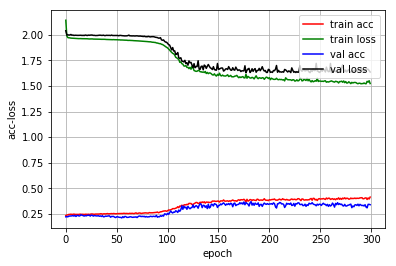

In [62]:
history.loss_plot('epoch')

In [63]:
loss, accuracy = model.evaluate(test_x, test_y)

print('test loss: ', loss)
print('test accuracy: ', accuracy)

618/618 [==============================] - 0s 55us/step
test loss:  1.5667488189191108
test accuracy:  0.4061488675068112
